<a href="https://colab.research.google.com/github/Sanjith0524/PokemonClassifier/blob/main/PokemonClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import webcolors
import glob

# Function to find the colour


In [ ]:
def close_col(requested_colour):
    min_colours = {}
    for name in webcolors.names("css3"):
        r, g, b = webcolors.name_to_rgb(name)
        rd = (r - requested_colour[0]) ** 2
        gd = (g - requested_colour[1]) ** 2
        bd = (b - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def colorname(rgb_tuple):
    try:
        hex_value = webcolors.rgb_to_hex(rgb_tuple)
        return webcolors.hex_to_name(hex_value)
    except ValueError:
        return close_col(rgb_tuple)

# Dominant Color extraction

Dominant Color extraction


Function to extract the dominant colour using a Kmeans cluster model.
Firstly the dominant colour is extracted and given as hex value which is then convrted to rbg and then finally to the color name

In [ ]:
def get_dom_color(img_path, ncol=3, visualize=False):
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((100, 100))
        imagearr = np.array(img)
        pixels = imagearr.reshape(-1, 3)
        black_mask = ~np.all(pixels < 30, axis=1)
        filt_pix = pixels[black_mask]

        if len(filt_pix) > 100:
            pixel_kmeans = filt_pix
        else:
            pixel_kmeans = pixels

        kmeans = KMeans(n_clusters=ncol, n_init=10)
        kmeans.fit(pixel_kmeans)
        labels = kmeans.labels_
        unique_labels, counts = np.unique(labels, return_counts=True)
        sorted_indices = np.argsort(-counts)
        colors = kmeans.cluster_centers_[sorted_indices].astype(int)
        color_perc = counts[sorted_indices] / len(labels) * 100

        hex_colors = []
        for color in colors:
            hex_color = '#%02x%02x%02x' % tuple(color)
            hex_colors.append(hex_color)

        if visualize:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title("Original Image")
            plt.axis('off')

            if len(filt_pix) > 100:
                filtered_img = np.zeros_like(imagearr)
                flat_mask = black_mask.reshape(-1)
                for i in range(3):
                    flat_img = imagearr.reshape(-1, 3)[:, i]
                    filtered_flat = np.zeros_like(flat_img)
                    filtered_flat[flat_mask] = flat_img[flat_mask]
                    filtered_img[:, :, i] = filtered_flat.reshape(100, 100)
            plt.subplot(1, 3, 2)
            all_labels = kmeans.predict(pixels)
            quantized_image = np.zeros_like(imagearr)
            for i, idx in enumerate(sorted_indices):
                cluster_mask = all_labels.reshape(img.size[1], img.size[0]) == idx
                quantized_image[cluster_mask] = colors[i]
            plt.imshow(quantized_image)
            plt.title(f"Quantized Image\n({ncol} colors)")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            dominant_colors_display = np.zeros((100, 100, 3), dtype=np.uint8)
            y_start = 0
            for i, color in enumerate(colors):
                height = int(color_perc[i])
                height = max(height, 1)
                y_end = min(y_start + height, 100)
                dominant_colors_display[y_start:y_end, :] = color
                plt.text(105, y_start + height // 2, f"{color_perc[i]:.1f}%",
                         va='center', ha='left', fontsize=8)
                text_color = 'white' if sum(color) < 380 else 'black'
                plt.text(50, y_start + height // 2, hex_colors[i],
                         va='center', ha='center', color=text_color, fontsize=8,
                         bbox=dict(facecolor=tuple(color / 255), edgecolor='none', pad=1))
                y_start = y_end

            plt.imshow(dominant_colors_display)
            plt.title("Dominant Colors\n(by percentage)")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            print("Dominant Colors (in order):")
            for i, hex_color in enumerate(hex_colors):
                print(f"{i+1}. {hex_color} - {color_perc[i]:.1f}%")

        color_info = []
        for i in range(len(colors)):
            color_dict = {
                'hex': hex_colors[i],
                'rgb': colors[i].tolist(),
                'percentage': color_perc[i]
            }
            color_info.append(color_dict)

        return hex_colors[0], color_info

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None, []

# Process Pokémon Images and Update the CSV

In [ ]:
def process_img(file_name, img_folder, ncol=3, show_samples=5):
    df = pd.read_csv(file_name)
    if 'Colour' in df.columns:
        df = df.drop('Colour', axis=1)
    first_two_cols = df.columns[:2].tolist()
    other_cols = df.columns[2:].tolist()
    new_column_order = first_two_cols + ['Colour'] + other_cols
    new_df = pd.DataFrame(columns=new_column_order)
    for col in first_two_cols + other_cols:
        new_df[col] = df[col]
    new_df['Colour'] = ''
    df = new_df
    image_files = glob.glob(os.path.join(img_folder, '*.*'))
    print(f"Found {len(image_files)} image files in {img_folder}")
    filename_to_path = {}
    for file_path in image_files:
        base_name = os.path.basename(file_path)
        filename_to_path[base_name] = file_path
    sample_count = 0

    for index, row in df.iterrows():
        pokemon_num = str(row['Num'])
        pokemon_name = row['Name']
        possible_filenames = [
            f"{pokemon_num}.png",
            f"{pokemon_num}.jpg",
            f"{pokemon_num}.jpeg"
        ]
        matching_file = None
        for f in possible_filenames:
            if f in filename_to_path:
                matching_file = filename_to_path[f]
                break
        if not matching_file:
            for fp in image_files:
                if pokemon_num in os.path.basename(fp):
                    matching_file = fp
                    break
        if not matching_file:
            print(f"No image found for Pokémon #{pokemon_num} ({pokemon_name})")
            df.at[index, 'Colour'] = 'Image not found'
            continue
        should_visualize = sample_count < show_samples
        dominant_color, color_info = get_dom_color(
            matching_file, ncol, visualize=should_visualize
        )
        if not dominant_color:
            df.at[index, 'Colour'] = 'Color not extracted'
            continue
        dominant_color_hex = dominant_color.lstrip('#')
        r = int(dominant_color_hex[0:2], 16)
        g = int(dominant_color_hex[2:4], 16)
        b = int(dominant_color_hex[4:6], 16)
        dominant_color_rgb = (r, g, b)
        color_name = colorname(dominant_color_rgb)
        df.at[index, 'Colour'] = color_name
        if should_visualize:
            print(f"Pokemon: {pokemon_name} (#{pokemon_num})")
            print(f"Image used: {os.path.basename(matching_file)}")
            print(f"Dominant color: {color_name}")
            print("-" * 50)
            sample_count += 1

    output_filename = file_name.replace('.csv', '_with_colors.csv')
    df.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")
    return df

# Main

Here the hex values are accurate but when converted to colour name the accuracy is reduced

Found 819 image files in /content/Pokemon


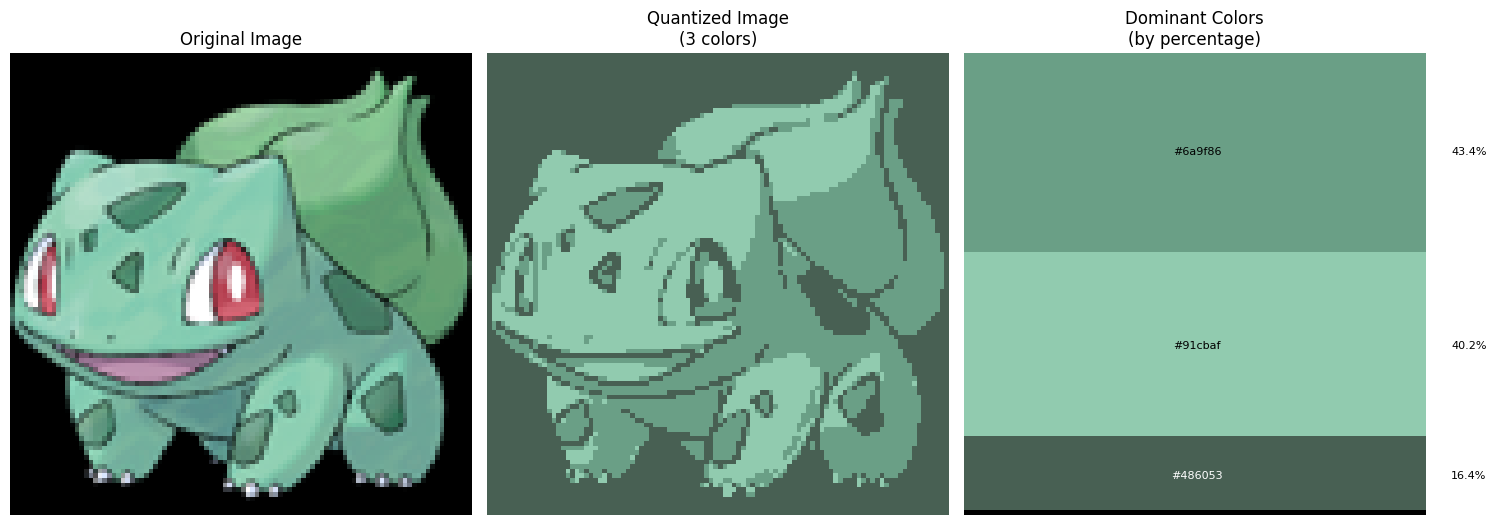

Dominant Colors (in order):
1. #6a9f86 - 43.4%
2. #91cbaf - 40.2%
3. #486053 - 16.4%
Pokemon: Bulbasaur (#1)
Image used: 1.png
Dominant color: cadetblue
--------------------------------------------------
Results saved to /content/PokemonData_with_colors.csv


In [ ]:
def test_extract(img_path, ncol=3):
    print(f"Testing color extraction on: {img_path}")
    dominant_color, color_info = get_dom_color(img_path, ncol, visualize=True)
    print(f"Dominant color: {dominant_color}")
    return dominant_color, color_info

csv_file = "/content/PokemonData.csv"
img_folder = "/content/Pokemon"
result_df = process_img(
    file_name=csv_file,
    img_folder=img_folder,
    ncol=3,
    show_samples=1
)